In [14]:
import logging
import sys
import os
from os import getenv
from os.path import abspath, basename, split,dirname
import tarfile
from shutil import copyfile
import random, glob
from skimage.util import random_noise
from skimage.transform import rotate
import time
import numpy as np
import math
import math as m

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Layer

from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3, EfficientNetB2,EfficientNetB6
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras import layers
from tensorflow import keras
#from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))

def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

In [16]:
num_classes = 28
image_size = 224  # We'll resize input images to this size
input_shape = (224,224, 3)
learning_rate = 0.001
batch_size = 64
hidden_units = 512
projection_units = 128
num_epochs = 10
dropout_rate = 0.5
temperature = 0.05

size = (image_size, image_size)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/train",
    image_size=size,
    batch_size=batch_size,
    interpolation='nearest'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/val",
    image_size=size,
    batch_size=batch_size,
    interpolation='nearest'
)

Found 19182 files belonging to 28 classes.
Found 7648 files belonging to 28 classes.


In [17]:
def rotate_tensor(image):
    degree = tf.random.normal([])*360
    image = tfa.image.rotate(image, degree * math.pi / 180)
    return image

def input_preprocess_train(image, label):
    image = rotate_tensor(image)
    image = tf.cast(image,'float32') #activate for densenet
    image = preprocess_input(image)
    return image, label

def input_preprocess_val(image, label):
    image = tf.cast(image,'float32')
    image = preprocess_input(image)
    return image, label

In [18]:
train_ds_c = train_ds.map(input_preprocess_train)
val_ds_c = val_ds.map(input_preprocess_val)

(64, 224, 224, 3) (64,)


(-0.5, 223.5, 223.5, -0.5)

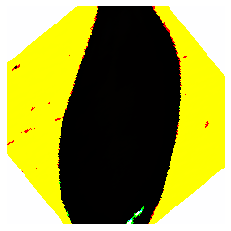

In [19]:
import matplotlib.pyplot as plt

for x_train, y_train in train_ds_c.take(1):
    print(x_train.shape, y_train.shape)
    
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

In [20]:
class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        #labels = K.argmax(y_true, axis=-1)
        #logits = self.get_logits(labels, y_pred)
        #loss = tf.losses.categorical_crossentropy(labels=labels, logits=logits)
        loss = tf.losses.categorical_crossentropy(y_true, y_pred,from_logits=True)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


In [21]:
def create_encoder(): 
    inputs = keras.Input(shape=input_shape)
    resnet = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs, pooling="avg")
    for layer in resnet.layers:
        layer.trainable = True
    #augmented = data_augmentation(inputs)
    outputs = resnet.output
    model = keras.Model(inputs=inputs, outputs=outputs, name="grains-encoder")
    return model

def create_encoder_bilinear():
    input_tensor = layers.Input(shape=input_shape)
    model1 = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=input_shape)
    model2 = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=input_shape)

    for layer in model1.layers[:-4]:
        layer.trainable = False
    for layer in model2.layers[:-7]:
        layer.trainable = False
        
    for i, layer in enumerate(model1.layers):
        layer._name = 'model1_' + layer.name

    last_layer1 = model1.get_layer('model1_relu')
    last_output1 = last_layer1.output

    for i, layer in enumerate(model2.layers):
        layer._name = 'model2_' + layer.name

    last_layer2 = model2.get_layer('model2_relu')
    #last_layer2 = model2.get_layer('model2_top_conv')
    last_output2 = last_layer2.output
    
    
    model1_ = tf.keras.Model(inputs=model1.input, outputs=last_output1)
    model2_ = tf.keras.Model(inputs=model2.input, outputs=last_output2)
    
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-3)
   
    
    model1_.compile(optimizer='adam',loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    model2_.compile(optimizer='adam',loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    
    d1=model1_.output
    d2=model2_.output

    bilinear = layers.Lambda(outer_product, name='outer_product1')([d1,d2])
    
    model = tf.keras.Model(inputs=model1.input, outputs=bilinear, name="grains-encoder")
    
    return model

def create_encoder_MDNet(img_dim=input_shape, num_pipelines=4, decrease_by=0.25):

    assert img_dim[0] == img_dim[1]
    assert num_pipelines > 1
    pipelines = []

    model_input = layers.Input(shape = img_dim)
    
    model = DenseNet121(weights='imagenet', include_top=False, input_shape=(None, None, 3), pooling='avg')
    
    for layer in model.layers:
        layer.trainable = True

    # Number of pipelines
    for pipeline_idx in range(num_pipelines):

        new_dim = int(img_dim[0] * (pipeline_idx * decrease_by)) if pipeline_idx != 0 else img_dim[0]
        crop_by = int(new_dim/2) if pipeline_idx != 0 else 0

        x = layers.Cropping2D(cropping = crop_by, name = 'Cropped_by_' + str(crop_by))(model_input)
        
        out = model(x)
        
        pipelines.append(out)
    
    model_output = layers.Concatenate(axis = -1)(pipelines)
    
    model = tf.keras.Model(inputs = model_input, outputs = model_output, name ="grains-encoder")
    
    return model

In [22]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)
    
class triplet_loss(keras.losses.Loss):
    def __init__(self, margin=1.0, kind='hard', name=None):
        super(triplet_loss, self).__init__(name=name)
        self.margin = margin
        self.kind = kind       

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        
        if self.kind == 'hard':
            loss = tfa.losses.triplet_hard_loss(labels, feature_vectors_normalized, margin=self.margin, soft=False)
        elif self.kind == 'soft':
            loss = tfa.losses.triplet_hard_loss(labels, feature_vectors_normalized, margin=self.margin, soft=True)
        elif self.kind == 'semihard':
            loss = tfa.losses.triplet_semihard_loss(labels, feature_vectors_normalized, margin=self.margin)
            
        return loss
    
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder_with_projection-head")
    return model

In [23]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [24]:
encoder = create_encoder()
#encoder = create_encoder_bilinear()
#encoder =  create_encoder_MDNet()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(optimizer='adam',
    loss=SupervisedContrastiveLoss(temperature),)
    #loss= triplet_loss(margin=1.0, kind='semihard'),)

lr_schedule= get_cosine_schedule_with_warmup(lr=0.0001, num_warmup_steps=4, num_training_steps=10)

encoder_with_projection_head.summary()
start = time.time()
history = encoder_with_projection_head.fit(train_ds_c,validation_data=val_ds_c, batch_size=batch_size, 
                                           callbacks=[lr_schedule],#steps_per_epoch=19182 / batch_size,
                                           epochs=10)

print('duration run',(time.time()-start)/60/60,' hours')

Model: "encoder_with_projection-head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
grains-encoder (Functional)  (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
Total params: 7,168,704
Trainable params: 7,085,056
Non-trainable params: 83,648
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
Epoch 1/10
300/300 [==============================] - 244s 812ms/step - loss: 4.5754 - val_loss: 4.7972

Epoch 00002: LearningRateScheduler reducing learning rate to 2.5e-05.
Epoch 2/10
277/300 [==========================>...] - ETA: 15s - loss: 3.0038

KeyboardInterrupt: 

In [25]:
def rotate_tensor(image):
    degree = tf.random.normal([])*360
    image = tfa.image.rotate(image, degree * math.pi / 180)
    return image

def input_preprocess_train(image, label):
    label = tf.one_hot(label, num_classes)
    image = rotate_tensor(image)
    image = tf.cast(image,'float32') #activate for densenet
    image = preprocess_input(image)
    return image, label

def input_preprocess_val(image, label):
    label = tf.one_hot(label, num_classes)
    image = tf.cast(image,'float32') #activate for densenet
    image = preprocess_input(image)
    return image, label

In [26]:
train_ds_s = train_ds.map(input_preprocess_train)
val_ds_s = val_ds.map(input_preprocess_val)

In [31]:
def create_classifier3(encoder,  dropout, fc_layers):
    inputs = keras.Input(shape=input_shape)
    #for layer in encoder.layers:
        #layer.trainable = True
    encoder.trainable = True 
    for layer in encoder.layers[:-1]:
        layer.trainable = False 
    x = encoder(inputs)
    #x = layers.Flatten()(x)
    for fc in fc_layers:
        x = layers.Dense(fc, activation='relu')(x) # New FC layer, random init
        x = layers.Dropout(dropout)(x)
        
    af_layer = ArcFace(output_dim=28, class_num=28, margin=0.5, scale=64.)  
    arcface_output = af_layer(x)
    model = tf.keras.Model(inputs,  arcface_output, name="grain-classifier")
    model.compile(optimizer='adam', loss=af_layer.loss, metrics=[acc_grain],run_eagerly=True)
    return model

def create_classifier(encoder):
    #encoder.trainable = True
    for layer in encoder.layers[:-1]:
        layer.trainable = False

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    #features = layers.Dropout(dropout_rate)(features)
    #features = layers.Dense(hidden_units, activation="relu")(features)
    #features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate),
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=[acc_grain],run_eagerly=True
    )
    return model

def create_classifier2(encoder,  dropout, fc_layers):
    inputs = keras.Input(shape=input_shape)
    #for layer in encoder.layers:
        #layer.trainable = True
    encoder.trainable = True 
    for layer in encoder.layers[:-1]:
        layer.trainable = False 
    x = encoder(inputs)
    #x = layers.Flatten()(x)
    for fc in fc_layers:
        x = layers.Dense(fc, activation='relu')(x) # New FC layer, random init
        x = layers.Dropout(dropout)(x)
        
    outputs = layers.Dense(num_classes, activation='softmax', name="pred")(x) # New softmax layer
    model = tf.keras.Model(inputs, outputs, name="cifar10-classifier")
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    return model

def build_model_attention(model):
    inputs = keras.Input(shape=input_shape)
    model.trainable = True
    for layer in model.layers[:]:
        layer.trainable = False
    #model.trainable = False
    pt_features = model(inputs)
    pt_depth = model.get_output_shape_at(0)[-1]
    bn_features = layers.BatchNormalization()(pt_features)
    
     # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = layers.Conv2D(64, kernel_size = (1, 1), padding = 'same', activation = 'swish')(layers.Dropout(0.5)(bn_features))
    attn_layer = layers.Conv2D(16, kernel_size = (1, 1), padding = 'same', activation = 'swish')(attn_layer)
    attn_layer = layers.Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'swish')(attn_layer)
    attn_layer = layers.Conv2D(1, kernel_size = (1, 1), padding = 'valid', activation = 'sigmoid')(attn_layer)
    
    # fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = layers.Conv2D(pt_depth,kernel_size=(1,1),padding = 'same', activation='linear',use_bias = False,weights = [up_c2_w] )
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = layers.multiply([attn_layer, bn_features])
    gap_features = layers.GlobalAveragePooling2D()(mask_features)
    gap_mask = layers.GlobalAveragePooling2D()(attn_layer)
    
     # To account for missing values from the attention model
    gap = layers.Lambda(lambda x: x[0] / x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = layers.Dropout(0.5)(gap)
    dr_steps = layers.Dropout(0.25)(tf.keras.layers.Dense(128, activation = 'swish')(gap_dr))
    
    concat = layers.BatchNormalization()(dr_steps)
    concat = layers.Dense(512, activation = 'swish')(concat)        
    concat = layers.Dropout(0.15)(concat)
    outputs = layers.Dense(28, activation="softmax", name="pred",dtype='float32')(concat)

    model = tf.keras.Model([inputs], [outputs], name="EfficientNet")
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    return model

In [32]:
#encoder_with_projection_head.save('encoder_with_projection_head_dense121')
encoder_with_projection_head = keras.models.load_model('encoder_with_projection_head_dense121',custom_objects={'acc_grain':acc_grain},compile=False)

In [33]:
model1 = tf.keras.Model(encoder_with_projection_head.get_layer('grains-encoder').input,encoder_with_projection_head.get_layer('grains-encoder').output)
#model1= tf.keras.Model(model1.input, model1.get_layer('conv5_block3_3_conv').output)

In [34]:
#classifier = create_classifier(model1)
#classifier = create_classifier2(model1, dropout=0.5, fc_layers=[512])
classifier = create_classifier3(model1, dropout=0.5, fc_layers=[512])
#classifier = build_model_attention(model1)
#classifier = build_model_bilinear(model1)

filename = 'best.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_acc_grain', verbose=1, save_best_only=True, mode='max')
lr_schedule= get_cosine_schedule_with_warmup(lr=0.001, num_warmup_steps=4, num_training_steps=10)

weights = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], [1,1,1,1,1,1,1,8.94,1,1,1,1,1,8.94,1,1,1,1,1,1,1,1,1,1,8.94,1,1,1]))

start = time.time()
history = classifier.fit(train_ds_s, validation_data=val_ds_s, batch_size=batch_size, epochs=10,shuffle=True,
                         callbacks=[lr_schedule], verbose=1, class_weight=weights
                        )

print('duration run',(time.time()-start)/60/60,' hours')

accuracy = classifier.evaluate(val_ds_s)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
Epoch 1/10
300/300 [==============================] - 264s 879ms/step - loss: 21.2570 - acc_grain: 0.0366 - val_loss: 3.3208 - val_acc_grain: 0.0207

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 2/10
300/300 [==============================] - 262s 875ms/step - loss: 15.2742 - acc_grain: 0.9418 - val_loss: 2.5314 - val_acc_grain: 0.9502

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 3/10
300/300 [==============================] - 262s 873ms/step - loss: 13.1406 - acc_grain: 0.9565 - val_loss: 2.3234 - val_acc_grain: 0.9663

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00075.
Epoch 4/10
300/300 [==============================] - 264s 880ms/step - loss: 12.3275 - acc_grain: 0.9616 - val_loss: 2.3085 - val_acc_grain: 0.9629

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/10
300/300 [==============================] - 26

KeyboardInterrupt: 

In [19]:
96.39%

SyntaxError: invalid syntax (<ipython-input-19-265111cba378>, line 1)

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import pandas as pd
import zipfile
import csv

start = time.time()

def load_class_list(class_list_file):
    class_list = []
    with open(class_list_file, 'r') as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            class_list.append(row[0])
    class_list.sort()
    return class_list

class_list = load_class_list('class_list.txt')

IMG_SIZE=224
LBL = dict(zip(class_list, range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

def init_dir(pth):
    if os.path.exists(pth):
        shutil.rmtree(pth)
    os.mkdir(pth)

logger.info("loading the model")
model = model_fn(args['model_dir'])
logger.info("Reading the test set")

res = []
for fn in glob.iglob(args['data_dir'] + 'val/**/*.png', recursive=True):
    file_name = os.path.basename(fn)
    path = os.path.abspath(fn)
    folder = os.path.split(os.path.dirname(path))[1]
    if len(file_name.split("-")) > 2:  # ignore master image with may grains, raw image names are in guid format
        im = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(im)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        pred = model.predict(img_preprocessed)
        top3 = (-pred[0]).argsort()[:3]
        res.append({'file_name': file_name, 'path': path, 'cls': folder, 'prediction':top3[0],  'proba_1':pred[0][top3[0]], 'prediction2':top3[1], 'proba_2':pred[0][top3[1]],  'prediction3':top3[2], 'proba_3':pred[0][top3[2]]})

df = pd.DataFrame(res)
df['prediction'] = df.prediction.map(cls_map)
df['prediction2'] = df.prediction2.map(cls_map)
df['prediction3'] = df.prediction3.map(cls_map)

from sklearn.metrics import accuracy_score

def w(x):
    if "_SOUND" in x:
        return 8.94 # weighting  Healthy grains more important than defective grains
    return 1

def scoring_fn(df):
    """
    Weighted Accuracy Metric 90% Healthy grains, 10% unhealthy grains
    """
    df['weight'] = df.cls.apply(w)
    return accuracy_score(df.cls,df.prediction,sample_weight=df.weight)

logger.info(f"predictions have shape of {df.shape}")

score = scoring_fn(df)
print ("Accuracy Score:" + str(score))
# write to the output location

print('Duration Run',(time.time()-start)/3600,' hours')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df['cls'], df['prediction']))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ticks=np.linspace(0, 27,num=28)
plt.figure(figsize=(15,15))
plt.imshow(confusion_matrix(df['cls'], df['prediction'],normalize='true'), interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [20]:
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
NUM_CLASSES=28
model = build_model(num_classes=NUM_CLASSES)
model.fit?

In [ ]:
image.random_rotation(90)

In [ ]:
 rotation_range=args.rotation,
      shear_range=args.shear,
      zoom_range=args.zoom,
      horizontal_flip=args.h_flip,
      vertical_flip=args.v_flip